# Proton tagging rate

This notebook is used to define a statistical model to estimate the proton tagging rate.


In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, binom
from numpy import random
import mplhep as hep
import pandas as pd
import uproot
import uproot3 as up3
import timeit
import seaborn as sns
from tqdm import tqdm
import math

### Event  model

The following model is defined to generate events:

   * Number of interactions per event follow Poisson statistics with mean value of $\mu$
   * Each interaction has the probability $f_{sd}$ to be diffractive 
   * **Diffractive interactions**:
     * $\beta$ is the efficiency to tag a proton from the diffractive interation
     * $p_{V}^{D}$ is the efficiency to reconstruct vertex from diffrative interaction
   * **Non-Diffractive interactions**:
     * no proton is generated
     * $p_{V}^{ND}$ is the efficiency to reconstruct vertex from diffrative interaction
     
The following function is used to generate events following the definitions above:
```python

def GenerateDataset(Nevents, mu, fSD, pV_ND, pV_D, beta):

```
with `mu`=$\mu$,    `fSD`=$f_{sd}$,    `pV_ND`=$p_{V}^{ND}$,    `pV_D`=$p_{V}^{D}$ and    `beta`=$\beta$

In [3]:
def GenerateDataset(Nevents, mu, fSD=0.3, pV_ND = 0.9, pV_D = 0.6, beta = 0.05):
    start = timeit.default_timer()
    nVtx=np.zeros(Nevents, dtype=np.uint32)
    nProtons=np.zeros(Nevents, dtype=np.uint32)
    Nint = random.poisson(mu,Nevents);

    for i in tqdm(range(Nevents)): #loop over all events
        random_numbers = random.rand(Nint[i]*4)
        for j in range(Nint[i]): # loop over all interactions in event
            #check collision type:
            if random_numbers[4*j+0] > fSD:
                #this is a non diffractive event
                if random_numbers[4*j+1] < pV_ND: 
                    nVtx[i]+=1
            else:
                #this is a diffractive event
                if random_numbers[4*j+2] < pV_D: 
                    nVtx[i]+=1
                if random_numbers[4*j+3] < beta: 
                    nProtons[i]+=1
        if nProtons[i]>1: nProtons[i]=0
    stop = timeit.default_timer()
    print('probability for PU proton in collision',fSD*beta)
    print('probability to form a vertex in collision',fSD*pV_D+(1-fSD)*pV_ND)
    print('Time: %2.2fsec for %d events'%(stop - start,Nevents))
    d = {'nvtx': nVtx, 'nprotons': nProtons, 'nint': Nint}
    return pd.DataFrame(data=d)

# Generation of toys

We will generate three different toy models:
   * `df1`: vertex reconstruction efficiency is 100%
   * `df2`: vertex reconstruction efficiency is <100%,but $p_{V}^{ND}=p_{V}^{D}$
   * `df3`: vertex reconstruction efficiency is <100%,and  $p_{V}^{ND}\neq p_{V}^{D}$
   

In [48]:
# Generate 10M events with 25% diffractive fraction, and beta=6%
N = 10000000; mu = 3; fSD=0.25; beta = 0.06;

In [49]:
pV_ND = 1; pV_D = 1;
df1=GenerateDataset(N, mu=mu, fSD = fSD, pV_D = pV_D, pV_ND = pV_ND, beta = beta)

100%|██████████| 10000000/10000000 [03:14<00:00, 51286.01it/s]

probability for PU proton in collision 0.015
probability to form a vertex in collision 1.0
Time: 195.98sec for 10000000 events


In [50]:
pV_ND = 0.85; pV_D = 0.85
df2=GenerateDataset(N, mu=mu, fSD = fSD, pV_D = pV_D, pV_ND = pV_ND, beta = beta)

100%|██████████| 10000000/10000000 [02:43<00:00, 60979.36it/s]

probability for PU proton in collision 0.015
probability to form a vertex in collision 0.85
Time: 164.88sec for 10000000 events


In [51]:
pV_ND = 8/9; pV_D = 1/3
df3=GenerateDataset(N, mu=mu, fSD = fSD, pV_D = pV_D, pV_ND = pV_ND, beta = beta)

100%|██████████| 10000000/10000000 [02:35<00:00, 64426.57it/s]


probability for PU proton in collision 0.015
probability to form a vertex in collision 0.75
Time: 156.17sec for 10000000 events


### Model validation plots

Plot of vertex multiplicity for the three models

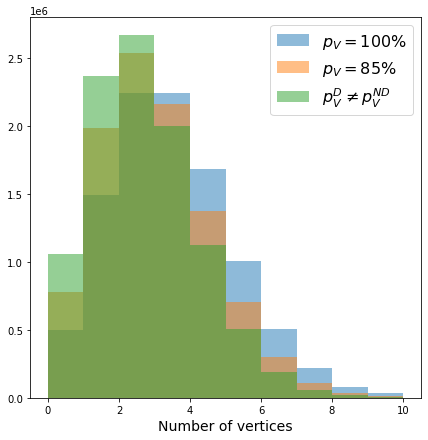

In [53]:
f, ax = plt.subplots(figsize=(7,7))
df1['nvtx'].plot.hist(bins=np.linspace(0,10,11), alpha=0.5, ax=ax, label=r'$p_V=$100%');
df2['nvtx'].plot.hist(bins=np.linspace(0,10,11), alpha=0.5, ax=ax, label=r'$p_V=$85%');
df3['nvtx'].plot.hist(bins=np.linspace(0,10,11), alpha=0.5, ax=ax, label=r'$p^{D}_V \neq p^{ND}_V$');
ax.set_xlabel('Number of vertices', fontsize = 14); ax.set_ylabel('')
ax.legend(loc=1, fontsize =16)
plt.show()

Proton tagging rate for the three models (profile the dataframes)

In [54]:
#make profiles
results=[]
for df in [df1, df2, df3]:
    binned = df[df['nvtx']<11].groupby('nvtx')
    result = binned['nprotons'].agg(['mean','sem'])
    result['x']=np.linspace(0,max(binned.groups.keys()),max(binned.groups.keys())+1)
    result['xerr']=0.5
    results.append(result)

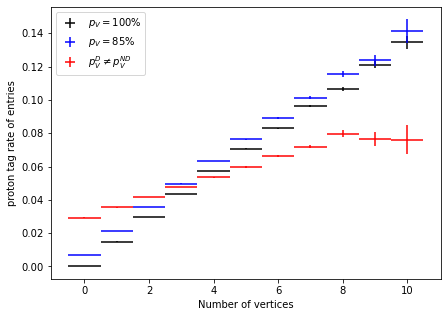

In [71]:
#plot profiles
f, ax = plt.subplots(figsize=(7,5))
results[0].plot(x='x',y='mean',xerr='xerr',yerr='sem',linestyle='none',capsize=0,color='black',label=r'$p_V=$100%',ax=ax)
results[1].plot(x='x',y='mean',xerr='xerr',yerr='sem',linestyle='none',capsize=0,color='blue',label=r'$p_V=$85%',ax=ax)
results[2].plot(x='x',y='mean',xerr='xerr',yerr='sem',linestyle='none',capsize=0,color='red',label=r'$p^{D}_V \neq p^{ND}_V$',ax=ax)
ax.set(xlabel='Number of vertices', ylabel='proton tag rate of entries')
ax.legend(loc=2)
plt.show()

### Saving to ROOT

One can save the samples to ROOT n-tuple:

In [63]:
df=df3 #save the third example
with up3.recreate("toys.root") as f:
    f["Events"] = uproot3.newtree({"nvtx": "int32", "nProtons": "int32", "nint": "int32"})
    f["Events"].extend({"nvtx": df['nvtx'], "nProtons": df['nprotons'], "nint": df['nint']})

# Stat model

Probability to measure a single proton vs number of additional vertices is given by:
$$ P(1|n_{vtx}) = f(n_{vtx}, f_{SD}, \beta_{D}, p_{V}^{D}, p_{V}^{ND}) $$

Where $f_{SD}$ is the fraction of diffractive interactions with $\beta_{D}$ the tagging proton efficiency from a diffractive interaction, $p_{V}^{D}$ and $p_{V}^{ND}$ are the vertex recontruction efficiency for diffractive or non-diffracgive interaction respectively.  

To derive the formula we define a set of orthogonal event selections $(k,k_d)$, where $k$ is the number of additional interactions where $k_d$ and $k-k_d$ are diffractive and non-diffractive respectively. Then the probability can be rewriten as:
$$ P(1|n_{vtx}) = P(1 \text{ and } n_{vtx} ) / P(n_{vtx}) = \Sigma_{k,k_d} P(1 \text{ and } n_{vtx} | k,k_d)  P(k,k_d) / P(n_{vtx}) $$

Since number of vertices and number of protons depends only on the type of the interactions, then this breakdown insure unconditionality: 
$$ P(1 \text{ and } n_{vtx} | k,k_d) = P(1| k,k_d) \cdot P( n_{vtx} | k,k_d) $$

then the probabilty will be of a form of:

$$ P(1|n_{vtx}) = \Sigma_{k,k_d} \left( P(1| k,k_d) \cdot P( n_{vtx} | k,k_d) \right) P(k,k_d) / P(n_{vtx}) $$


Let's derive the two expressions, the probability to observe event with $p$ protons:

$$ P( p | k,k_d) = \binom{k_d}{p} \cdot \beta_D^{p}\left( 1 - \beta_D\right)^{k_d-p} $$  

For $p\leq k_d$, and in particular for $p=1$:

$$ P( 1 | k,k_d) = k_d\beta_D\left( 1 - \beta_D\right)^{k_d-1}$$  

Probability for $k$ interactions with $k_d$ diffractive:

$$P(k,k_d) = \frac{\mu^k e^{-\mu}}{k!} \cdot \binom{k}{k_d} \cdot f_D ^ {k_d} \left( 1- f_D \right) ^ {k - k_d}$$


Probability for number of vertices:
$$ P(n_{vtx}) = \frac{\left(p_V\mu\right)^{n_{vtx}} e^{-p_V\mu}}{n_{vtx}!} $$ 

When $p_V^{ND} = p_V^{D} = p_V $ we obtain:

$$ P(1|n_{vtx}) = f_{SD}\beta \left( 1- \beta \right)^n e^{-f_{SD}\beta\mu(1-p_V)}\left( \frac{n}{1-f_{SD}\beta} +  \mu(1-p_V) \right) $$ 

The general soluation is:

$$ P(1|n_{vtx}) = \beta_{V} \left( 1- \beta_{V}\right)^{n-1} e^{-\alpha}\left( n + \frac{(1-\beta_V)\alpha}{\beta_V} \right) $$ 

where $\beta_{V} = f_{SD}\beta\cdot p_V^D/p_V$,  $\alpha = f_{SD}\beta(1-p_{V}^{D})\mu$ and $p_{V} = f_{SD}p_{V}^{D} + (1-f_{SD})p_{V}^{ND}$

In [84]:
def Prob(n,pvd,pvnd,beta,fSD,mu):
    # probability to measure 1 proton given measured n vertices
    
    pv = fSD*pvd + (1-fSD)*pvnd
    betaV = beta*fSD*pvd / pv
    alpha = mu*(1-pvd)*beta*fSD
    
    return betaV*np.power(1-betaV,n-1)*np.exp(-alpha)*(n+alpha*(1-betaV)/betaV)

### Model validation

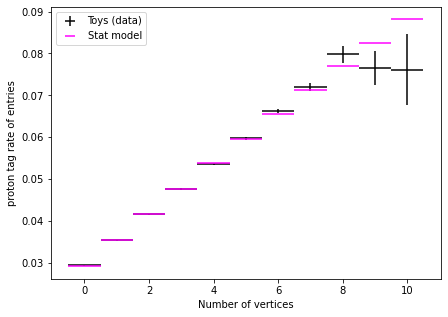

In [86]:
#plot ptoron tag rate vs number of vertices and the function

f, ax = plt.subplots(figsize=(7,5))
results[2].plot(x='x',y='mean',xerr='xerr',yerr='sem',linestyle='none',capsize=0,color='black',label='Toys (data)',ax=ax)
x = np.linspace(0,10,11); 
y = [Prob(int(_n),pvd=pV_D, pvnd=pV_ND, beta=beta, fSD=fSD, mu=mu) for _n in x]
plt.errorbar(x=x,y=y,xerr=0.5,label='Stat model',linestyle='none',color='magenta')
ax.set(xlabel='Number of vertices', ylabel='proton tag rate of entries')
ax.legend(loc=2)
plt.show()


